In [1]:
#for tweaking figure for paper

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec

from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
import random
mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 



Populating the interactive namespace from numpy and matplotlib


In [2]:
def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [ ]:
#load Hubble data 
hubble_meta_name = download_from_dropbox('https://www.dropbox.com/s/oqxk3pyms6u2851/meta_catalog_3_23_2016_hubble.fits?dl=1')
old_data = Table.read(hubble_meta_name)
#load ferengi data 
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/r88l9u5fcsbppui/ferengi_all_weighted_and_meta.fits?dl=1")
old_f_data = Table.read(ferengi_filename) 

# Re-calculating Surface Brightness for Hubble and FERENGI

To be consistent in comparing surface brightness measurments for Hubble and FERENGI images, we compute $\mu$ directly. We'll use the formula from Griffith et al. 2012 for both:

$\mu = mag + 2.5 \cdot log_{10}(2 \cdot (b/a) \cdot \pi \cdot r_{e}^2)$

All parameters are measured by SExtractor; Hubble from ACS-GC and FERENGI from Tom's thesis. Explicitly:

## Hubble:

mag = MAG_BEST (best mag from AUTO or ISOCOR mag)

b = IMAGE_B_HI (b-axis)

a = IMAGE_A_HI (a-axis)

$r_{e}$ = effective half-light radius in arcseconds. We use the value FLUX_RADIUS and convert to arcseconds using the conversion 0.05''/pix for COSMOS, and 0.03''/pix for all other surveys.


*note: HI refers to the redder wavelength band in each survey, as follows:

COSMOS: HI = I (814)

AEGIS: HI = I (814)

GEMS: HI = z (850)

## FERENGI:

mag = automag_i (auto mag)

b = b_image

a = a_image

$r_{e}$ = effective half-light radius in arcseconds. We use the value R50 and convert to arcseconds using 0.03''/pix for AEGIS, GEMS, GOODS and 0.05''/pix for COSMOS. 


## Note: Parameters that might be inconsistent:

1) Due to data available, we use MAG_BEST for Hubble and automag for FERENGI. These may be inconsistent in crowded fields if MAG_BEST = MAG_ISOCOR. 

2) We are not 100% sure that R50 from Tom's data is equivalent to FLUX_RADIUS from SExtractor. The manual suggests that this is the case, but it should be verified..somehow.



In [85]:
#Add new sb measurement to tables

def new_sb(mag,r_pix,a,b,pix_scale):
    #convert to r from pix to arcsec:
    r = r_pix*pix_scale
    sb = mag + 2.5*log10(2*b/a*pi*r**2)
    return sb

In [131]:
# Add table to Hubble

data = old_data.copy(copy_data=True)

gz_sb = Table.Column(name='GZ_MU_I',length=len(data))
data.add_columns([gz_sb])
for gal in data:
    if gal['imaging']=='COSMOS           ': # pix scale = 0.05''/pix
        gal['GZ_MU_I']=new_sb(gal['MAG_BEST_HI'],gal['FLUX_RADIUS_HI'],gal['A_IMAGE_HI'],gal['B_IMAGE_HI'],0.05)
    else: # pix scale = 0.03''/pix
        gal['GZ_MU_I']=new_sb(gal['MAG_BEST_HI'],gal['FLUX_RADIUS_HI'],gal['A_IMAGE_HI'],gal['B_IMAGE_HI'],0.03)

#Add to FERENGI

f_data = old_f_data.copy(copy_data=True)

gz_sb = Table.Column(name='GZ_MU_I',length=len(f_data))
f_data.add_columns([gz_sb])
for gal in f_data:
    gal['GZ_MU_I']=new_sb(gal['automag_i'],gal['r50'],gal['a_image'],gal['b_image'],0.03)


In [132]:
#purple/green plot for hubble more better:
#Select ferengi ranges so contours make sense

# Limit to galaxies that have data at z_sim = z0, since that's what we're normalizing to.
z0 = 0.3
unique_galaxies = set(f_data['objid'])
z0ind = np.zeros(len(f_data),dtype=bool)
eps = 1e-3
for ug in unique_galaxies:
    ind = (f_data['objid'] == ug)
    if f_data[ind]['sim_redshift'].min() < (z0+eps):
        z0ind[ind] = True
        
data_z0 = f_data[z0ind]

#smooth out redshifts 
#for gal in data_z0:
#    z=round(gal['sim_redshift']*1000,1)
#    gal['sim_redshift'] = random.randrange(z-50,z+50)/1000.


In [122]:
data.write('/home/mel/Desktop/sbdata.fits')

In [172]:
## Eye of Sauron again, but flip: Hubble = contours, ferenti = histogram

SB = 'GZ_MU_I'

#define ferengi histogram
z_bins=np.linspace(0-.05,2.05,22)
z_bins=[z for z in z_bins]
mu_bins = np.linspace(16,26,20)
mu_bins = [m for m in mu_bins]
fhist,fxedges,fyedges=np.histogram2d(data_z0['sim_redshift'],data_z0[SB],bins=(z_bins,mu_bins))
fextent=[fxedges[0],fxedges[-1],fyedges[0],fyedges[-1]]
histy,xedges,yedges=np.histogram2d(data['Z_BEST'],data[SB],range=((0,2),(16,26)))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]


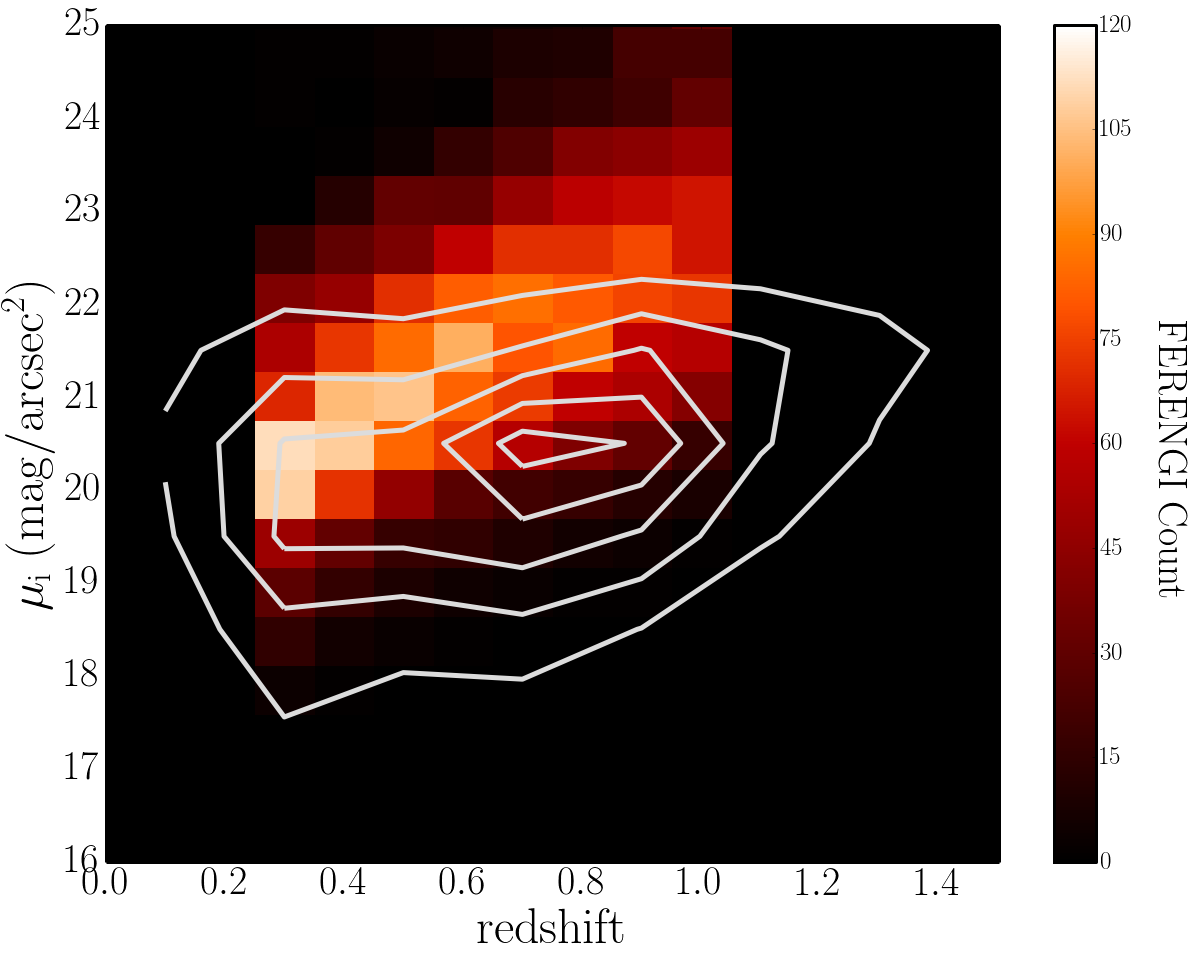

In [174]:
#plot 

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

f=plt.figure(figsize=(20,15))
vmax = 120
plt.imshow(fhist.T,origin='lower',extent=fextent,interpolation='nearest',aspect='auto',cmap=cm.gist_heat,vmax=vmax)
plt.colorbar()
f_contour=plt.contour(histy.T,origin='lower',extent=extent,colors='#DCDCDC',linewidths=5)
#plt.clabel(f_contour, inline=1, fontsize=20) to get contour levels

plt.xlim(0,1.5)
plt.ylim(16,25)

plt.xlabel(r'$\mathrm{redshift}$',fontsize=50)
plt.ylabel(r'$\mathrm{\mu_{i}~(mag/arcsec^2)}$',fontsize=50)
plt.tick_params(labelsize=40)

f.text(.85,.6,'$\mathrm{FERENGI~Count}$',fontsize=40,rotation = 270)

#plt.savefig('../writeup/figures/eye_of_sauron.pdf')


# Old version of plot for comparison, using MU_HI and mu_max_i

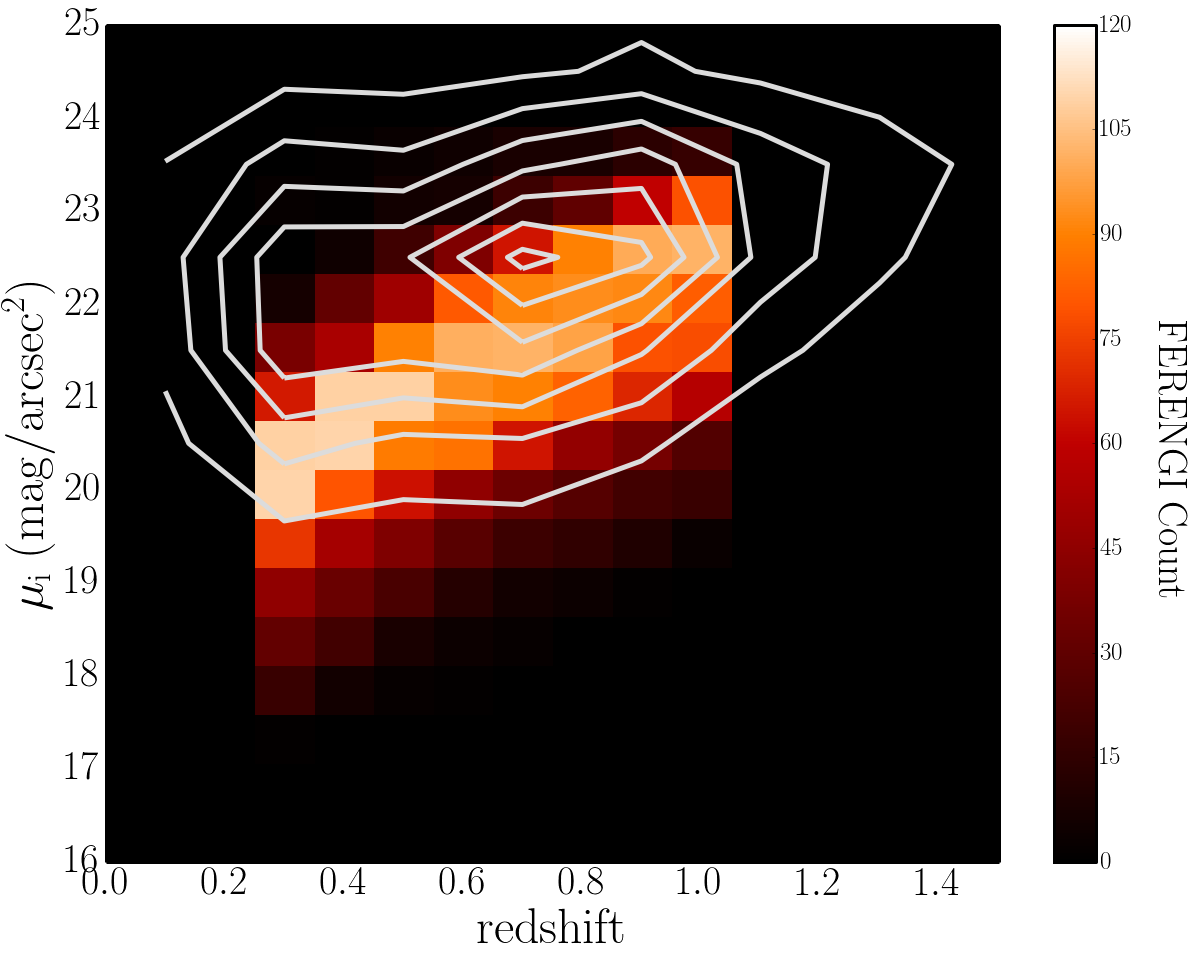

In [181]:
## Eye of Sauron again, but flip: Hubble = contours, ferenti = histogram


#define ferengi histogram
z_bins=np.linspace(0-.05,2.05,22)
z_bins=[z for z in z_bins]
mu_bins = np.linspace(16,26,20)
mu_bins = [m for m in mu_bins]
fhist,fxedges,fyedges=np.histogram2d(data_z0['sim_redshift'],data_z0['mu_max_i'],bins=(z_bins,mu_bins))
fextent=[fxedges[0],fxedges[-1],fyedges[0],fyedges[-1]]
histy,xedges,yedges=np.histogram2d(data['Z_BEST'],data['MU_HI'],range=((0,2),(16,26)))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

#plot 

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

f=plt.figure(figsize=(20,15))
vmax = 120
plt.imshow(fhist.T,origin='lower',extent=fextent,interpolation='nearest',aspect='auto',cmap=cm.gist_heat,vmax=vmax)
plt.colorbar()
f_contour=plt.contour(histy.T,origin='lower',extent=extent,colors='#DCDCDC',linewidths=5)
#plt.clabel(f_contour, inline=1, fontsize=20) to get contour levels

plt.xlim(0,1.5)
plt.ylim(16,25)

plt.xlabel(r'$\mathrm{redshift}$',fontsize=50)
plt.ylabel(r'$\mathrm{\mu_{i}~(mag/arcsec^2)}$',fontsize=50)
plt.tick_params(labelsize=40)

f.text(.85,.6,'$\mathrm{FERENGI~Count}$',fontsize=40,rotation = 270)


In [176]:
#Eye of SAURON by survey
imagings = list(set(data['imaging']))
imagings

['AEGIS            ', 'COSMOS           ', 'GEMS             ']

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


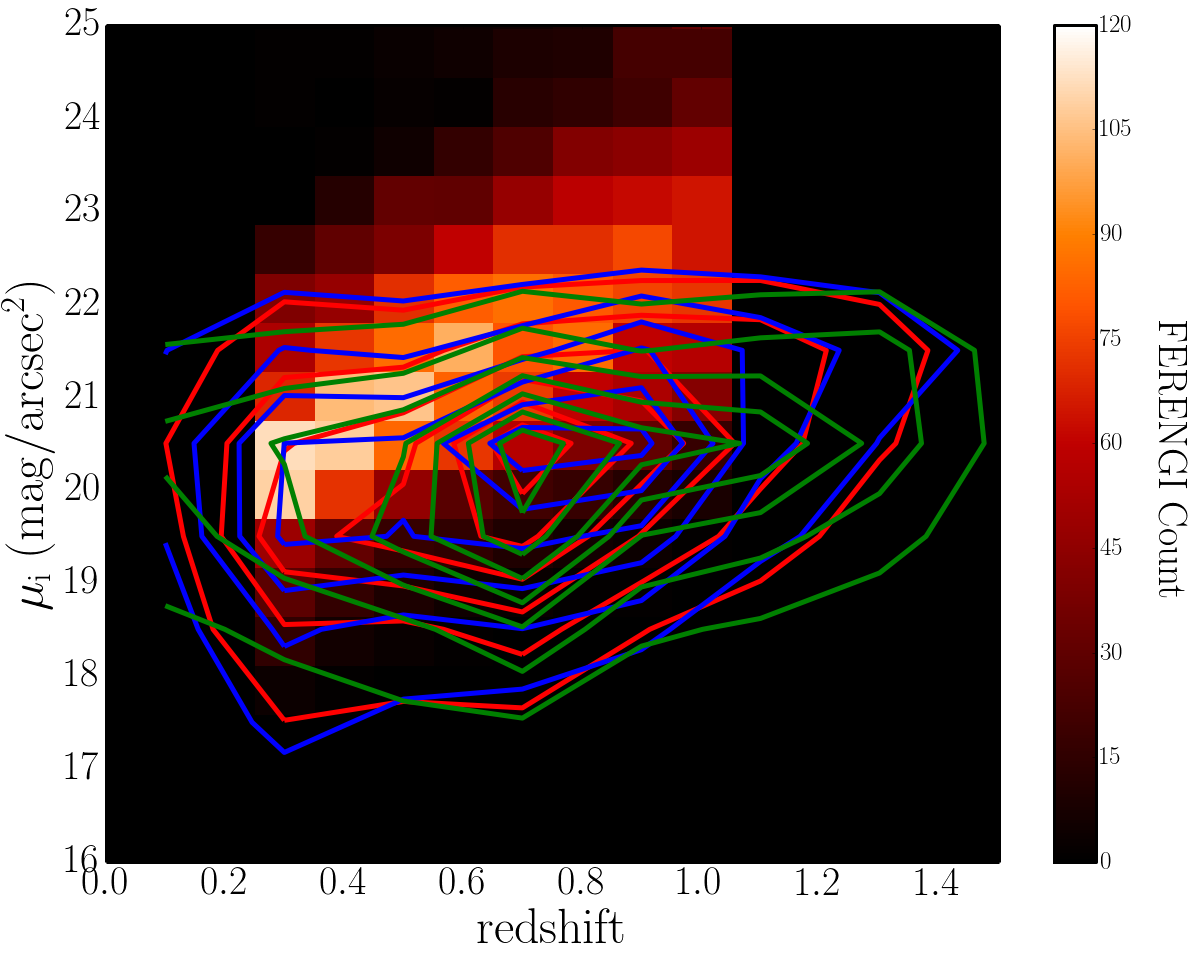

In [179]:
## Eye of Sauron again, but flip: Hubble = contours, ferenti = histogram

aegis = (data['imaging']=='AEGIS            ')
#define hubble
ahisty,xedges,yedges=np.histogram2d(data[aegis]['Z_BEST'],data[aegis][SB],range=((0,2),(16,26)))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

cosmos = (data['imaging']=='COSMOS           ')
#define hubble
chisty,xedges,yedges=np.histogram2d(data[cosmos]['Z_BEST'],data[cosmos][SB],range=((0,2),(16,26)))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

gems = (data['imaging']=='GEMS             ')
#define hubble
ghisty,xedges,yedges=np.histogram2d(data[gems]['Z_BEST'],data[gems][SB],range=((0,2),(16,26)))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

#plot 

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

f=plt.figure(figsize=(20,15))
vmax = 120
plt.imshow(fhist.T,origin='lower',extent=fextent,interpolation='nearest',aspect='auto',cmap=cm.gist_heat,vmax=vmax)
plt.colorbar()
f_contour=plt.contour(ahisty.T,origin='lower',extent=extent,colors='r',linewidths=5,label='AEGIS')
f_contour=plt.contour(chisty.T,origin='lower',extent=extent,colors='b',linewidths=5,label='COSMOS')
f_contour=plt.contour(ghisty.T,origin='lower',extent=extent,colors='g',linewidths=5,label='GEMS')
plt.legend()
#plt.clabel(f_contour, inline=1, fontsize=20) to get contour levels

plt.xlim(0,1.5)
plt.ylim(16,25)

plt.xlabel(r'$\mathrm{redshift}$',fontsize=50)
plt.ylabel(r'$\mathrm{\mu_{i}~(mag/arcsec^2)}$',fontsize=50)
plt.tick_params(labelsize=40)

f.text(.85,.6,'$\mathrm{FERENGI~Count}$',fontsize=40,rotation = 270)

